In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving models and preprocessors
import os
from datetime import datetime # For feature engineering

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model Algorithm (Example: XGBoost)
import xgboost as xgb

# --- Configuration ---
MODEL_NAME_PREFIX = "dep_delay" # Used for naming saved files
TARGET_COLUMN = "DepartureDelay"
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)


# CRISP-DM Phase: Data Understanding (Brief Recap) & Preparation 

In [3]:


# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# 2. Define Target Variable (y) and Initial Features (X_initial)
if TARGET_COLUMN not in df.columns:
    raise ValueError(f"Target column '{TARGET_COLUMN}' not found in DataFrame.")

# Drop rows where target is NaN (cannot train or evaluate on these)
df.dropna(subset=[TARGET_COLUMN], inplace=True)
print(f"Shape after dropping NaNs in target '{TARGET_COLUMN}': {df.shape}")

y = df[TARGET_COLUMN]
X_initial = df.drop(columns=[TARGET_COLUMN, 'FlightID', 'ArrivalDelay', 'ReasonForDelay']) # Drop target, ID, and other potential leakages/outcomes

# 3. Feature Engineering
print("\n--- Feature Engineering ---")

# Datetime features from 'ScheduledTime'
if 'ScheduledTime' in X_initial.columns:
    X_initial['ScheduledTime'] = pd.to_datetime(X_initial['ScheduledTime'], errors='coerce')
    X_initial.dropna(subset=['ScheduledTime'], inplace=True) # Drop if ScheduledTime is unparseable and critical

    X_initial['Scheduled_Hour'] = X_initial['ScheduledTime'].dt.hour
    X_initial['Scheduled_Minute'] = X_initial['ScheduledTime'].dt.minute # Could be less useful than hour
    X_initial['Scheduled_DayOfWeek'] = X_initial['ScheduledTime'].dt.dayofweek # Monday=0, Sunday=6
    X_initial['Scheduled_Month'] = X_initial['ScheduledTime'].dt.month
    X_initial['Scheduled_DayOfYear'] = X_initial['ScheduledTime'].dt.dayofyear
    X_initial['Is_Weekend'] = X_initial['Scheduled_DayOfWeek'].isin([5, 6]).astype(int)
    
    
    
    X_initial = X_initial.drop(columns=['ScheduledTime']) # Drop original datetime string
    print("Engineered datetime features from ScheduledTime.")
else:
    print("Warning: 'ScheduledTime' column not found for feature engineering.")


# Align X and y after potential drops from datetime parsing
y = y.loc[X_initial.index]
print(f"Shape of X_initial after feature engineering: {X_initial.shape}")
print(f"Shape of y after aligning: {y.shape}")

# 4. Identify Feature Types for Preprocessing
numerical_features = X_initial.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()



print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")


# 5. Split Data into Training and Test sets BEFORE fitting preprocessor
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")


# 6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Median is robust to outliers
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])


preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, [col for col in numerical_features if col in X_train.columns]),
    ('cat', categorical_pipeline, [col for col in categorical_features if col in X_train.columns])
], remainder='drop') # Drop any columns not specified




Shape after dropping NaNs in target 'DepartureDelay': (32940, 32)

--- Feature Engineering ---
Engineered datetime features from ScheduledTime.
Shape of X_initial after feature engineering: (16470, 33)
Shape of y after aligning: (16470,)

Identified Numerical Features: ['FlightDuration', 'BaggageHandlers', 'GroundCrew', 'FuelTrucks', 'CleaningCrew', 'Passengers', 'SecurityChecks', 'RunwayDelay', 'PreviousFlightDelay', 'AircraftTurnaroundTime', 'CheckInQueueTime', 'SecurityWaitTime', 'BaggageClaimBelts', 'CustomsOfficers', 'ImmigrationOfficers', 'Scheduled_Hour', 'Scheduled_Minute', 'Scheduled_DayOfWeek', 'Scheduled_Month', 'Scheduled_DayOfYear', 'Is_Weekend']
Identified Categorical Features: ['Airline', 'DepartureAirport', 'ArrivalAirport', 'OriginAirport', 'Gate', 'ScheduledArrivalTime', 'AircraftType', 'WeatherCondition', 'GateAvailability', 'GateType', 'LoungeUsage', 'OnTimePerformance']

Training set shape: X_train=(13176, 33), y_train=(13176,)
Test set shape: X_test=(3294, 33), y_

# CRISP-DM Phase: Modeling

In [4]:
# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed_np = preprocessor.fit_transform(X_train) # fit_transform on X_train

feature_names_processed = list(preprocessor.get_feature_names_out())
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_processed, index=X_train.index)
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"First 5 processed feature names: {feature_names_processed[:5]}")


X_test_processed_np = preprocessor.transform(X_test) 
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_processed, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed.shape}")


# 8.  XGBoost Regressor)
print("\n--- Model Training ---")
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=100,             
    learning_rate=0.1,            
    max_depth=5,                 
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1                     
    
)



xgb_model.fit(X_train_processed, y_train)
print("Model training complete.")






--- Fitting Preprocessor ---
Shape of X_train_processed: (13176, 111)
First 5 processed feature names: ['num__FlightDuration', 'num__BaggageHandlers', 'num__GroundCrew', 'num__FuelTrucks', 'num__CleaningCrew']
Shape of X_test_processed: (3294, 111)

--- Model Training ---
Model training complete.


# CRISP-DM Phase: Evaluation 


--- Model Evaluation ---

--- Training Set Metrics ---
R-squared (R2): 0.2606
Mean Absolute Error (MAE): 4.7911
Mean Squared Error (MSE): 64.2681
Root Mean Squared Error (RMSE): 8.0167

--- Test Set Metrics ---
R-squared (R2): 0.0073
Mean Absolute Error (MAE): 5.3281
Mean Squared Error (MSE): 85.5535
Root Mean Squared Error (RMSE): 9.2495


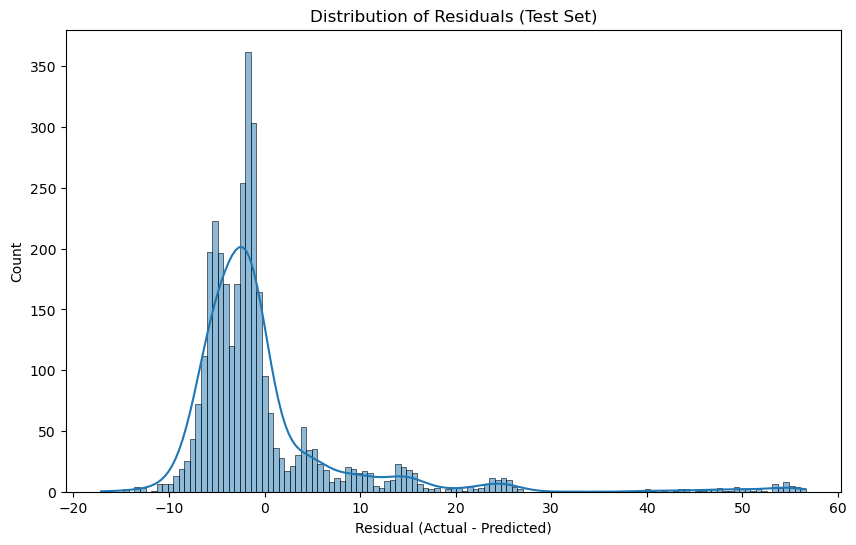

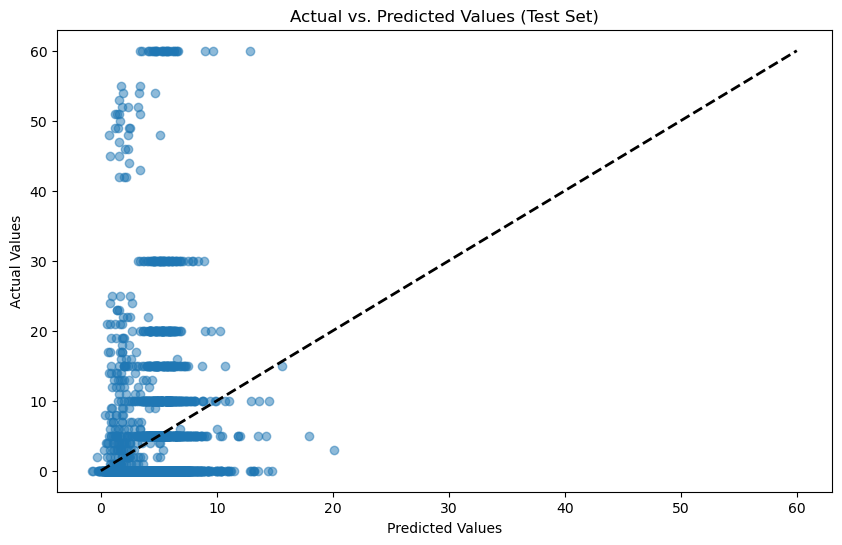

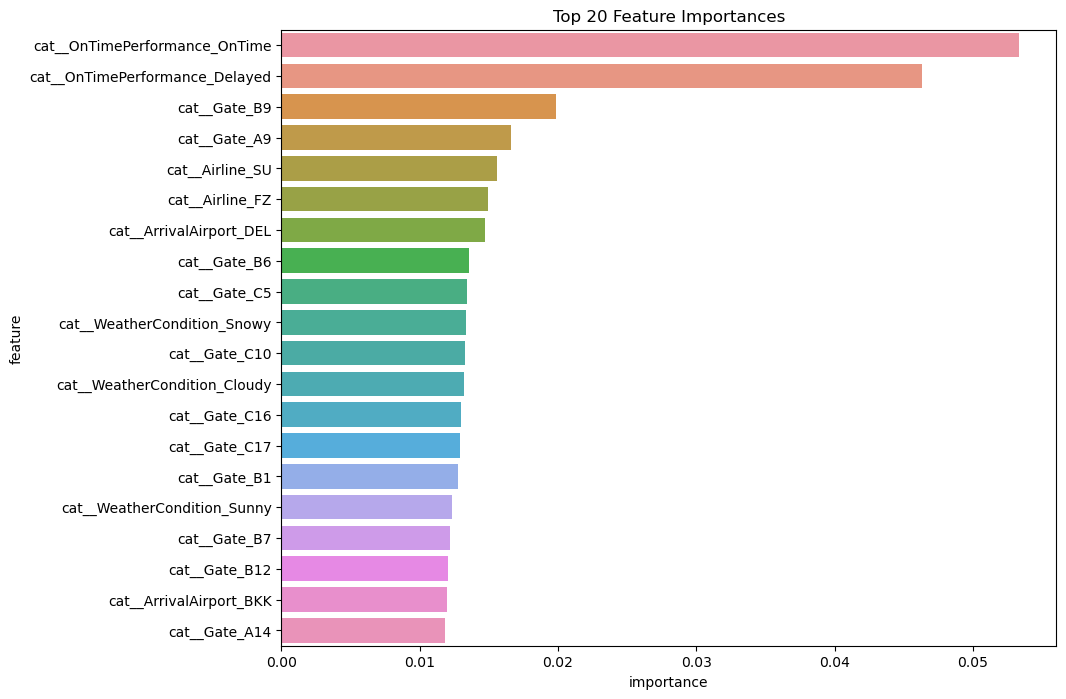

In [5]:

print("\n--- Model Evaluation ---")
y_pred_train = xgb_model.predict(X_train_processed)
y_pred_test = xgb_model.predict(X_test_processed)

print("\n--- Training Set Metrics ---")
print(f"R-squared (R2): {r2_score(y_train, y_pred_train):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_train, y_pred_train):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_train, y_pred_train):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_train, y_pred_train)):.4f}")

print("\n--- Test Set Metrics ---")
print(f"R-squared (R2): {r2_score(y_test, y_pred_test):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred_test):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred_test)):.4f}")

# Plotting residuals (example)
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_test
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Test Set)')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, y_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Values (Test Set)')
plt.show()

# Feature Importance (if model supports it, like XGBoost or RandomForest)
if hasattr(xgb_model, 'feature_importances_'):
    importances = xgb_model.feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names_processed, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(20) # Top 20

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Top 20 Feature Importances')
    plt.show()

In [6]:
# --- CRISP-DM Phase: Deployment (Saving Artifacts) ---
print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor
preprocessor_filename = f"preprocessor_{MODEL_NAME_PREFIX}.pkl"
preprocessor_path = os.path.join(MODELS_META_DIR, preprocessor_filename)
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to: {preprocessor_path}")

# 2. Save the list of Processed Feature Names
feature_names_filename = f"feature_names_{MODEL_NAME_PREFIX}.pkl"
feature_names_path = os.path.join(MODELS_META_DIR, feature_names_filename)
joblib.dump(feature_names_processed, feature_names_path) # Save the list of names
print(f"Feature names saved to: {feature_names_path}")

# 3. Save the Trained Model
model_filename = f"delay_time_estimation_{MODEL_NAME_PREFIX}.pkl" # Matching your dashboard's naming convention

final_model_name_for_dashboard = "delay_time_estimation_dep.pkl" 
model_path = os.path.join(MODELS_DIR, final_model_name_for_dashboard)
joblib.dump(xgb_model, model_path)
print(f"Trained model saved to: {model_path}")




--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_dep_delay.pkl
Feature names saved to: ../models_meta/feature_names_dep_delay.pkl
Trained model saved to: ../models/delay_time_estimation_dep.pkl
